<a href="https://colab.research.google.com/github/Farmhouse121/Wilmott-Articles/blob/main/Do_the_Right_Thing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("Installing yfinance and arch and getting the data...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from warnings import filterwarnings ; filterwarnings('ignore',category=FutureWarning) # I don't care
from yfinance import download
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from statsmodels.regression.linear_model import OLS
from statsmodels.api import add_constant
from arch.univariate import ARX, GARCH, GeneralizedError
from datetime import datetime
from scipy.stats import chi2 as density
zero,one,two,four,three,five,ten,hundred=0e0,1e0,2e0,3e0,4e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

# get the daily returns from Yahoo! Finance
ticker='SPY'
data=download(ticker,'1999-03-11','2019-12-31')
data.index=pd.DatetimeIndex(data.index).to_period('B')  # set calendar to business days
data['Return']=data['Adj Close'].pct_change()*hundred   # compute returns including splits etc.
data['LagReturn']=data['Return'].shift()                # compute returns lagged by one trading day
data.dropna(inplace=True)                               # remove any dates that are not properly 'bars', often due to holidays not properly removed
data.loc[data["Volume"]==0,"Volume"]=np.nan             # change zero volume to NA should it exist
in_sample,out_sample=data.loc[data.index<='2009-12-31'].copy(),data.loc[data.index>='2010-01-01'].copy()
print("In sample data...")
display(in_sample)
print("Out of sample data...")
display(out_sample)

Installing yfinance and arch and getting the data...
[*********************100%***********************]  1 of 1 completed
In sample data...


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
1999-03-15,129.937500,131.250000,129.500000,131.218750,85.466301,5394400.0,1.425072,-0.956907
1999-03-16,131.125000,131.656250,130.468750,130.718750,85.140656,4547500.0,-0.381022,1.425072
1999-03-17,130.687500,130.937500,129.625000,130.156250,84.774269,4524100.0,-0.430331,-0.381022
1999-03-18,129.781250,132.375000,129.750000,132.250000,86.137955,3506300.0,1.608608,-0.430331
1999-03-19,132.312500,132.625000,129.687500,129.687500,84.673843,5526700.0,-1.699728,1.608608
...,...,...,...,...,...,...,...,...
2009-12-24,112.190002,112.599998,112.000000,112.480003,88.193909,39677500.0,0.473435,0.196897
2009-12-28,112.900002,112.989998,112.320000,112.720001,88.382103,87508500.0,0.213387,0.473435
2009-12-29,113.010002,113.029999,112.550003,112.559998,88.256638,80572500.0,-0.141958,0.213387


Out of sample data...


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn
Date,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,88.860390,118944600.0,1.696012,-0.959844
2010-01-05,113.260002,113.680000,112.849998,113.629997,89.095619,111579900.0,0.264718,1.696012
2010-01-06,113.519997,113.989998,113.430000,113.709999,89.158333,116074400.0,0.070389,0.264718
2010-01-07,113.500000,114.330002,113.180000,114.190002,89.534706,131091100.0,0.422140,0.070389
2010-01-08,113.889999,114.620003,113.660004,114.570000,89.832649,126402800.0,0.332768,0.422140
...,...,...,...,...,...,...,...,...
2019-12-23,321.589996,321.649994,321.059998,321.220001,307.621582,52990000.0,0.152790,0.438417
2019-12-24,321.470001,321.519989,320.899994,321.230011,307.631134,20270000.0,0.003105,0.152790
2019-12-26,321.649994,322.950012,321.640015,322.940002,309.268707,30911200.0,0.532317,0.003105


In [ ]:
print("Fitting AR(1) model to %s Returns in sample...\n" % ticker)
ols_model=OLS(in_sample['Return'],add_constant(in_sample['LagReturn'])).fit()
print(ols_model.summary())
print("IC = %g." % np.sqrt(ols_model.rsquared))

Fitting AR(1) model to SPY Returns in sample...

                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     12.10
Date:                Thu, 20 Oct 2022   Prob (F-statistic):           0.000511
Time:                        19:40:00   Log-Likelihood:                -4752.0
No. Observations:                2719   AIC:                             9508.
Df Residuals:                    2717   BIC:                             9520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [ ]:
print("Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...\n")
model = ARX(in_sample["Return"],lags=1)
model.volatility = GARCH(1, 1, 1)
model.distribution = GeneralizedError()
ged_model=model.fit(update_freq=0)
print(ged_model.summary())
print("IC = %g." % np.sqrt(ged_model.rsquared))

from scipy.stats import chi2 as density
X2,dof=two*(ged_model.loglikelihood-ols_model.llf),len(ged_model.params)-len(ols_model.params)-1 # extra one for the variance
print("\nMaximum Likelihood Ratio Test vs OLS Model\nχ²(%d) = %f, p value = %g" % (dof,X2,one-density(dof).cdf(X2)))

Fitting AR(1)xAGARCH(1,1) model with GED innovations to Returns in sample...

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4034.2750552961484
            Iterations: 17
            Function evaluations: 157
            Gradient evaluations: 17
                               AR - GJR-GARCH Model Results                               
Dep. Variable:                             Return   R-squared:                       0.003
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                              GJR-GARCH   Log-Likelihood:               -4034.28
Distribution:      Generalized Error Distribution   AIC:                           8082.55
Method:                        Maximum Likelihood   BIC:                           8123.90
                                                    No. Observations:                 2718
Date:                            Thu, Oct 20 2022   Df Residuals:         

Compute out-of-sample alphas for both models.


,Open,High,Low,Close,Adj Close,Volume,Return,LagReturn,OLS Alpha,GED Alpha
Date,,,,,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,88.860390,118944600.0,1.696012,-0.959844,0.075663,0.076338
2010-01-05,113.260002,113.680000,112.849998,113.629997,89.095619,111579900.0,0.264718,1.696012,-0.101206,-0.033151
2010-01-06,113.519997,113.989998,113.430000,113.709999,89.158333,116074400.0,0.070389,0.264718,-0.005888,0.025855
2010-01-07,113.500000,114.330002,113.180000,114.190002,89.534706,131091100.0,0.422140,0.070389,0.007054,0.033866
2010-01-08,113.889999,114.620003,113.660004,114.570000,89.832649,126402800.0,0.332768,0.422140,-0.016371,0.019365
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,321.589996,321.649994,321.059998,321.220001,307.621582,52990000.0,0.152790,0.438417,-0.017455,0.018694
2019-12-24,321.470001,321.519989,320.899994,321.230011,307.631134,20270000.0,0.003105,0.152790,0.001566,0.030469
2019-12-26,321.649994,322.950012,321.640015,322.940002,309.268707,30911200.0,0.532317,0.003105,0.011535,0.036640


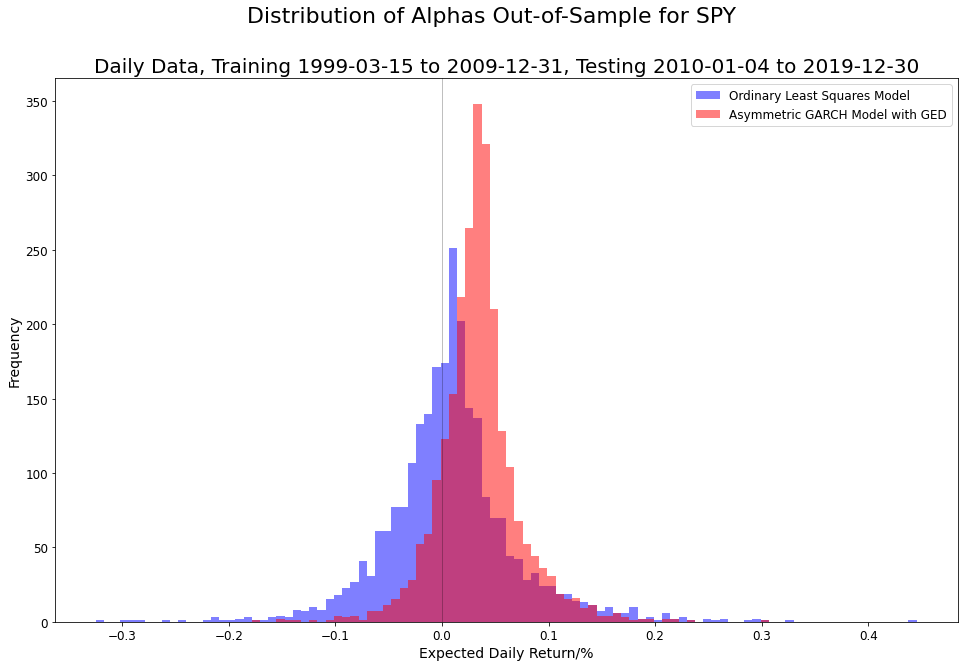

In [ ]:
print("Compute out-of-sample alphas for both models.")
out_sample['OLS Alpha']=ols_model.params[0]+ols_model.params[1]*out_sample['LagReturn']
out_sample['GED Alpha']=ged_model.params[0]+ged_model.params[1]*out_sample['LagReturn']
display(out_sample)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
sample,bins,patches=plot.hist(out_sample['OLS Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='blue',alpha=0.5,label='Ordinary Least Squares Model')
sample,bins,patches=plot.hist(out_sample['GED Alpha'],
                              bins=np.linspace(out_sample[['OLS Alpha','GED Alpha']].min().min(),out_sample[['OLS Alpha','GED Alpha']].max().max(),101),
                              color='red',alpha=0.5,label='Asymmetric GARCH Model with GED')
title='Distribution of Alphas Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.legend(fontsize=12)
plot.set_xlabel('Expected Daily Return/%',fontsize=14)
plot.set_ylabel('Frequency',fontsize=14)
plot.tick_params(labelsize=12)
plot.axvline(color='black',linewidth=1,alpha=0.25)
figure.savefig(title+".png",dpi=300);

Simulate trading out of sample for both alphas. Assuming zero transaction costs...
Basic Summary Data for SPY:


,Sample,Mean,StDev,Kurtosis,IC,Sharpe,StdErr
Model,,,,,,,
OLS,2515.0,0.014496,0.927584,8.260505,4.259358,0.248084,0.316635
GED,2515.0,0.057199,0.925932,8.346514,4.259358,0.980633,0.318018



Test for Sharpe Ratio Consistency
χ² = 5.30605, d.o.f. = 1, p Value = 0.0212515

Leverage of Improvements
Q = 2.3085


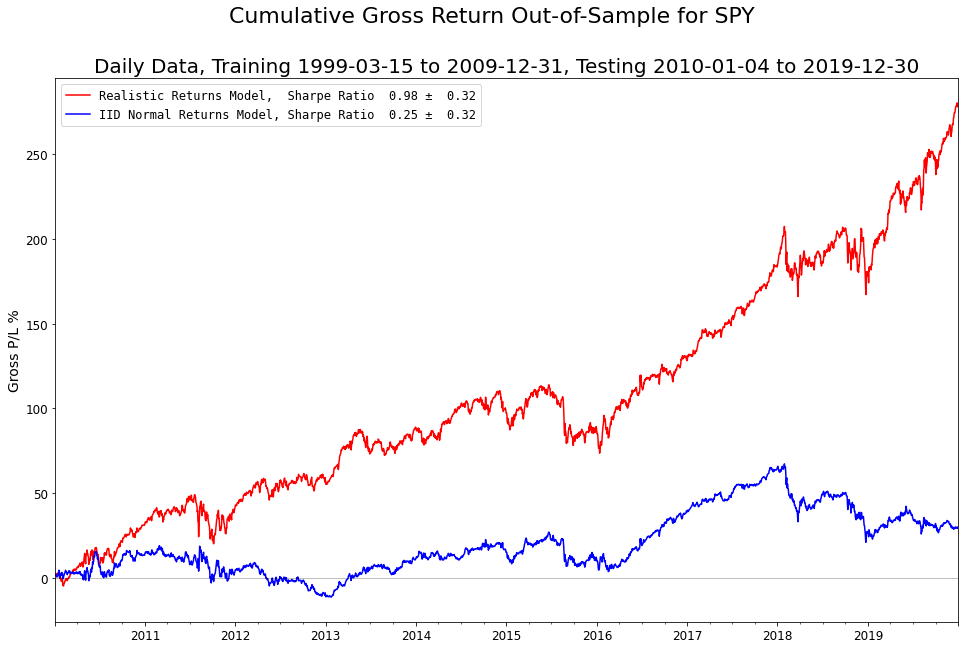

In [ ]:
print("Simulate trading out of sample for both alphas. Assuming zero transaction costs...")
stats,annualize=pd.DataFrame({'Model':[],'Sample':[],'Mean':[],'StDev':[],'Kurtosis':[],'IC':[],'Sharpe':[],'StdErr':[]}).set_index('Model'),252e0

for prefix in 'OLS','GED':
    out_sample["%s Holding" % prefix]=np.sign(out_sample["%s Alpha" % prefix]) # note, alpha was known at end of prior day, assumes position established then
    out_sample["%s Gross P/L" % prefix]=out_sample["Return"]*out_sample["%s Holding" % prefix] # return today on position established yesterday
    out_sample["%s Total P/L" % prefix]=np.exp(np.cumsum(np.log(one+out_sample["%s Gross P/L" % prefix]/hundred)))*hundred-hundred # compute compounded P/L
    stats.loc[prefix,"Sample"]=out_sample["%s Gross P/L" % prefix].count()    
    stats.loc[prefix,"Mean"]=out_sample["%s Gross P/L" % prefix].mean()
    stats.loc[prefix,"StDev"]=out_sample["%s Gross P/L" % prefix].std()
    stats.loc[prefix,"Kurtosis"]=out_sample["%s Gross P/L" % prefix].kurt()+three # function as specificed returns the adjusted kurtosis
    stats.loc[prefix,"IC"]=out_sample[["Return","%s Alpha" % prefix]].corr().iloc[0,1]*hundred

stats["Sharpe"]=stats["Mean"]/stats["StDev"]*np.sqrt(annualize) # yeah, no risk free rate but its basically been zero for this entire period, 252 trading days per year in US
stats["StdErr"]=np.sqrt(annualize/stats["Sample"]*(one+(stats["Kurtosis"]-one)/(four*annualize)*stats["Sharpe"]**2)) # standard error of Sharpe Ratio with kurtosis

print("Basic Summary Data for %s:" % ticker)
display(stats)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
out_sample['GED Total P/L'].plot(ax=plot,color='Red',label='Realistic Returns Model,  Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['GED','Sharpe'],stats.loc['GED','StdErr']))
out_sample['OLS Total P/L'].plot(ax=plot,color='Blue',label='IID Normal Returns Model, Sharpe Ratio %5.2f ± % 5.2f' % (stats.loc['OLS','Sharpe'],stats.loc['OLS','StdErr']))
title='Cumulative Gross Return Out-of-Sample for %s' % ticker
subtitle='Daily Data, Training %s to %s, Testing %s to %s' % (in_sample.index[0],in_sample.index[-1],out_sample.index[0],out_sample.index[-1])
figure.suptitle(title,fontsize=22)
plot.set_title(subtitle,fontsize=20)
plot.set_xlabel(None)
plot.set_ylabel('Gross P/L %',fontsize=14)
plot.tick_params(labelsize=12)
plot.axhline(color='black',linewidth=1,alpha=0.25)
pl.setp(plot.legend(loc='upper left',fontsize=12).texts,family='monospace');
figure.savefig(title+".png",dpi=300)

chi2,dof=(stats.loc['GED','Sharpe']-stats.loc['OLS','Sharpe'])**2/(stats['StdErr'].max()**2),1
print("\nTest for Sharpe Ratio Consistency\nχ² = %g, d.o.f. = %d, p Value = %g" % (chi2,dof,one-density.cdf(chi2,dof)))
print("\nLeverage of Improvements\nQ = %g" % ((stats["Sharpe"].max()-stats["Sharpe"].min())/(np.sqrt((stats['StdErr']**2).sum()/two))))